# Superstore - Time Series Analysis and Forecasting

Dataset: <a href="https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls">Sample - Superstore Sales</a>

## Familiarizing with the dataset and its variables

### Importing libraries

In [1]:
# importing libraries that will be used in this project
import datetime
import seaborn as sns
import pandas as pd              # data analysis and manipulation
from scipy.stats import pearsonr # correlation
import numpy as np               # deviation
import matplotlib.pyplot as plt  # plot chart
import pmdarima as pm            # auto-ARIMA and forecasting
import itertools                 # grid search ARIMA
import pylab                     # time-series decomposition
import statsmodels.api as sm     # time-series decomposition
import warnings

from pylab import rcParams                                                  # time-series decomposition
from statsmodels.tsa.stattools import kpss                                  # stationarity test KPSS
from statsmodels.tsa.stattools import adfuller                              # stationarity test Dickey-Fuller
from statsmodels.tsa.seasonal import seasonal_decompose                     # time-series decomposition
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf    # ACF and PACF

%matplotlib inline
sns.set(color_codes = True)
warnings.filterwarnings("ignore")

### Loading the data

In [2]:
df = pd.read_excel("superstore.xls") # importing dataset "superstore"

In [3]:
print("Dataset dimension: ", df.shape) # display the dimension of the dataset
print("\nDataset data types: \n", df.dtypes) # checking data types

print("\nMin and Max dates: ", df['Order Date'].min(), df['Order Date'].max())

Dataset dimension:  (9994, 21)

Dataset data types: 
 Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

Min and Max dates:  2014-01-03 00:00:00 2017-12-30 00:00:00


Based on the information above, we can get an idea of what we will be working with: what data is available for the analysis, the dataset dimension and its types. We have a good 4-year sales data.

In [4]:
df.head() # display the top 5 rows

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df.tail() # display the last 5 rows

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.248,3,0.2,4.1028
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2,0.0,15.6332
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.576,2,0.2,19.3932
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,13.3200
9993,9994,CA-2017-119914,2017-05-04,2017-05-09,Second Class,CC-12220,Chris Cortes,Consumer,United States,Westminster,...,92683,West,OFF-AP-10002684,Office Supplies,Appliances,"Acco 7-Outlet Masterpiece Power Center, Wihtou...",243.160,2,0.0,72.9480


By looking at the top and last 5 rows of the dataset it is hard to tell if there are any duplications, missing or null values. That being said, it is important to apply other techniques to clean up the spreadsheet before we start exploring the data.

## Data preprocessing

This step includes removing columns we do not need, check missing values, and aggregate sales by date.

### Checking duplicate rows

In [6]:
duplicate_rows_df = df[df.duplicated()] # filter duplicate rows
print("Number of duplicate rows: ", duplicate_rows_df) # print the number of duplicate rows

Number of duplicate rows:  Empty DataFrame
Columns: [Row ID, Order ID, Order Date, Ship Date, Ship Mode, Customer ID, Customer Name, Segment, Country, City, State, Postal Code, Region, Product ID, Category, Sub-Category, Product Name, Sales, Quantity, Discount, Profit]
Index: []

[0 rows x 21 columns]


There are no duplicate rows in this dataset. If there were duplicate rows, this is when they would have been removed.

### Checking for missing or null values

In [7]:
print("Number of null fields: \n", df.isnull().sum())

Number of null fields: 
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


There are no null fields in this dataset. If there were null fields, we would have to analyze and treat them accordingly by replacing or dropping them, for example.

### Identifying irrelevant columns 

At this point, it is important to have a clear understanding of the objective of the project and then decide what is relevant or not for the analysis. Columns that will be removed from this dataset:

- Row ID
- Order ID
- Ship Date
- Ship Mode
- Customer Name
- Product ID

In [8]:
df = df.drop(['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer Name', 'Product ID'], axis = 1)

### Renaming the columns

Renaming the columns making sure they are following the best practices for variable and method naming (e.g. lowercase, no special characters, etc) typically makes them easier to read and understand.

In [9]:
df = df.rename(columns = {'Order Date' : 'order_date', 'Customer ID' : 'customer_id', 'Segment' : 'customer_segment',
                          'Country' : 'country', 'City' : 'city', 'State' : 'state', 'Postal Code' : 'postal_code', 
                          'Region' : 'region', 'Category' : 'product_category', 'Sub-Category' : 'product_subcategory',
                          'Product Name' : 'product_name', 'Sales' : 'sales', 'Quantity' : 'quantity',
                          'Discount' : 'discount', 'Profit' : 'profit'})

In [10]:
df.head(1)

,order_date,customer_id,customer_segment,country,city,state,postal_code,region,product_category,product_subcategory,product_name,sales,quantity,discount,profit
0,2016-11-08,CG-12520,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136


### Encoding Categorical Values

In [11]:
print('Customer Segment:\n', df['customer_segment'].value_counts())

print('\nProduct Subcategory:\n', df['product_subcategory'].value_counts())

print('\nRegion:\n', df['region'].value_counts())

Customer Segment:
 Consumer       5191
Corporate      3020
Home Office    1783
Name: customer_segment, dtype: int64

Product Subcategory:
 Binders        1523
Paper          1370
Furnishings     957
Phones          889
Storage         846
Art             796
Accessories     775
Chairs          617
Appliances      466
Labels          364
Tables          319
Envelopes       254
Bookcases       228
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: product_subcategory, dtype: int64

Region:
 West       3203
East       2848
Central    2323
South      1620
Name: region, dtype: int64


In [12]:
df["customer_segment"] = df["customer_segment"].astype('category')
df["customer_segment"] = df["customer_segment"].cat.codes

In [13]:
df["region"] = df["region"].astype('category')
df["region"] = df["region"].cat.codes

In [14]:
df["product_subcategory"] = df["product_subcategory"].astype('category')
df["product_subcategory"] = df["product_subcategory"].cat.codes
df.head(3)

,order_date,customer_id,customer_segment,country,city,state,postal_code,region,product_category,product_subcategory,product_name,sales,quantity,discount,profit
0,2016-11-08,CG-12520,0,United States,Henderson,Kentucky,42420,2,Furniture,4,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2016-11-08,CG-12520,0,United States,Henderson,Kentucky,42420,2,Furniture,5,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,2016-06-12,DV-13045,1,United States,Los Angeles,California,90036,3,Office Supplies,10,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


### Indexing with Time Series Data

In [15]:
df = df.set_index('order_date')
df.index

DatetimeIndex(['2016-11-08', '2016-11-08', '2016-06-12', '2015-10-11',
               '2015-10-11', '2014-06-09', '2014-06-09', '2014-06-09',
               '2014-06-09', '2014-06-09',
               ...
               '2015-05-17', '2015-05-17', '2016-09-29', '2017-11-17',
               '2017-11-17', '2014-01-21', '2017-02-26', '2017-02-26',
               '2017-02-26', '2017-05-04'],
              dtype='datetime64[ns]', name='order_date', length=9994, freq=None)

### Extracting weekday, date and year of purchase

The month and year of the purchase were put in separate columns to facilitate the analysis.

In [16]:
df['weekday'] = pd.DatetimeIndex(df.index).weekday
df['month'] = pd.DatetimeIndex(df.index).month
df['year'] = pd.DatetimeIndex(df.index).year

### Filter Product Category

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [17]:
df = df.loc[df['product_category'] == 'Furniture']
furniture = df.loc[df['product_category'] == 'Furniture']

## Data Exploration

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics often using statistical graphs and other data visualization methods. Through the process of EDA, we can get a better understanding of the data set variables and the relationship between them, making it easier to discover patterns, detect outliers and anomalies, and test underlying assumptions.

### Correlation between two variables

Heat Maps is a type of plot which is necessary when we need to find the dependent variables. One of the best way to find the relationship between the features can be done using heat maps.

Correlation ranges from -1 to +1. Values closer to zero means there is no linear trend between the two variables. The close to 1 the correlation is the more positively correlated they are

<AxesSubplot:>

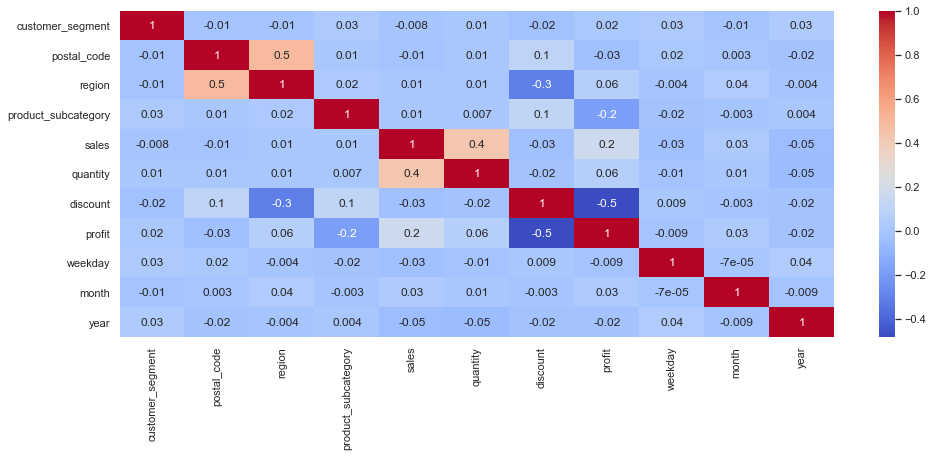

In [18]:
# Finding the relations between the variables
plt.figure(figsize = (16,6))
correlation = df.corr()
sns.heatmap(correlation, cmap = "coolwarm", annot = True, fmt='.1g')

The heatmap reveals some interesting patterns. We can see:

- A strong positive relationship between sales and the quantity
- A strong negative relationship between discount and the profit
- A strong negative relationship between discount and the region

In [19]:
# Test to see if sales and regions are correlated
stat, p = pearsonr(df.sales, df.product_subcategory)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the two samples are independent.')
else:
	print('Probably there is a dependency between the samples.')

stat=0.010, p=0.635
Probably the two samples are independent.


The first number in the returned tuple is the computed sample correlation coefficient 𝑟, and the second number is the p-value of the test. In this case, the evidence that there is any non-zero correlation is strong.

### Which product category generates most income?

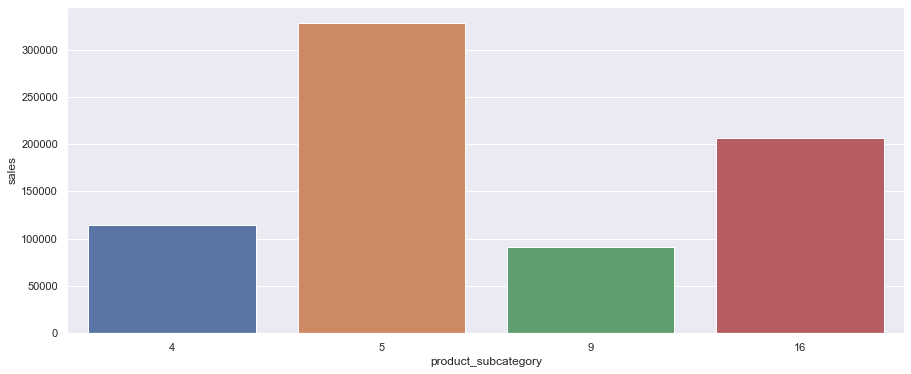

In [20]:
cat = df[["product_subcategory", "sales"]].groupby(['product_subcategory'], as_index = False).sum()

plt.figure(figsize=(15,6))
sns.barplot(x = 'product_subcategory', y = 'sales', data = cat)
plt.show()

The product category that generates most income is ...

### Which product subcategory is the most profitable?

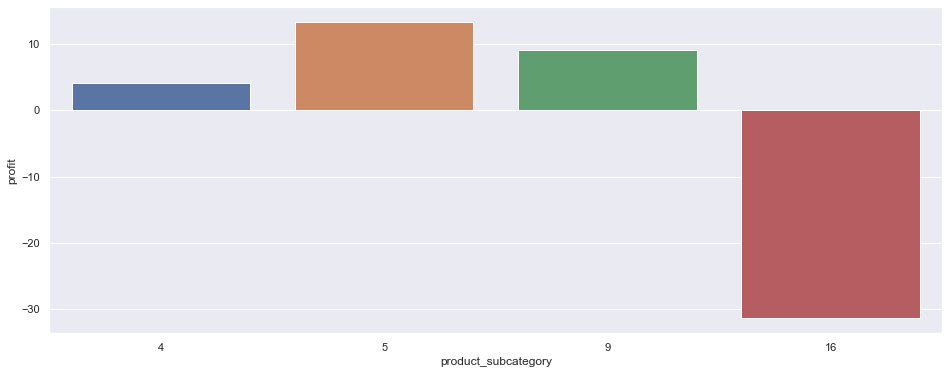

In [21]:
cat = df[["product_subcategory", "profit"]].groupby(['product_subcategory'], as_index = False).median()

plt.figure(figsize=(16,6))
sns.barplot(x = 'product_subcategory', y = 'profit', data = cat)
plt.show()

The most profitable product category is ...

### Which region should be chosen for expansion and which products should it focus on?

<AxesSubplot:xlabel='region', ylabel='profit'>

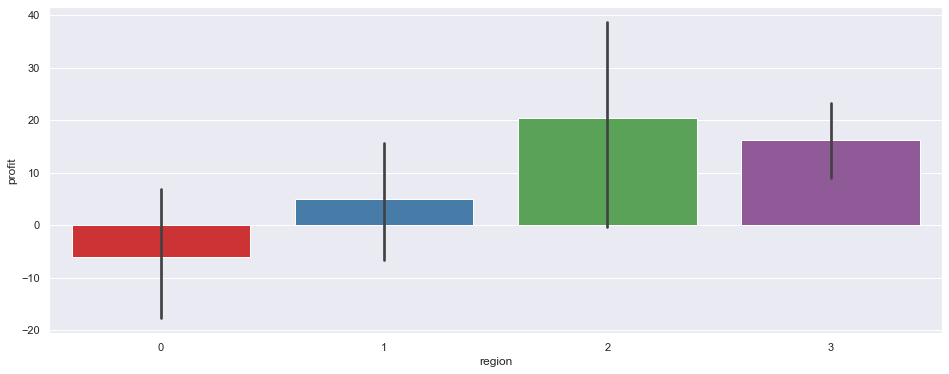

In [22]:
plt.figure(figsize=(16,6))
sns.barplot(df['region'],df['profit'],palette='Set1')

The most profitable region is ..., hence the expansion plan should be based on this region.

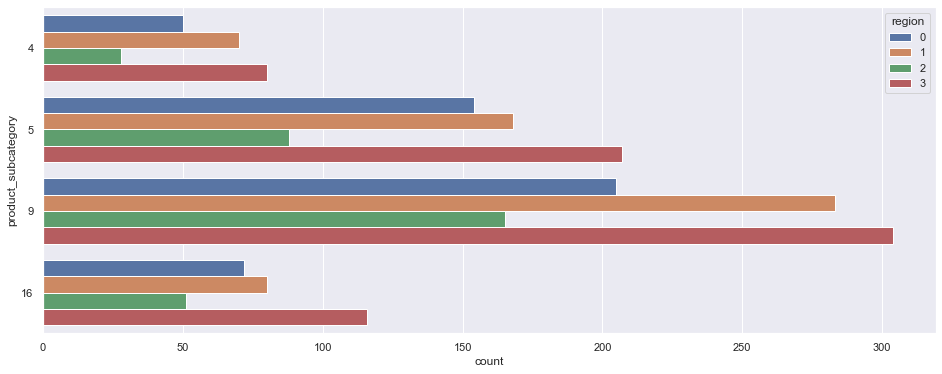

In [23]:
plt.figure(figsize=(16,6))
sns.countplot(y ='product_subcategory', hue = "region", data = df) 
plt.show()

xxx and xxx are the most sold product in XXXXX and these products should be focused on for expansion.

### Which day of the week has maximum sales?

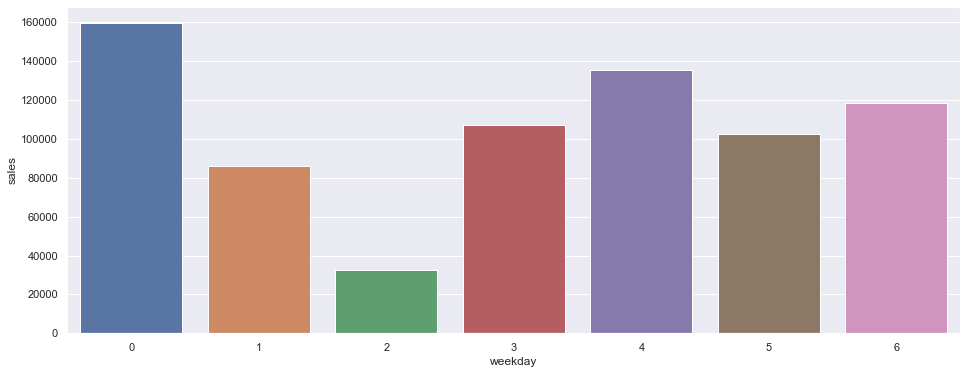

In [24]:
weekday = df[["weekday", "sales"]].groupby(['weekday'], as_index = False).sum()

plt.figure(figsize=(16,6))
sns.barplot(x = 'weekday', y = 'sales', data = weekday)
plt.show()

Sales is highest on Sundays probably because it is the weekend. Interestingly, Thursday is a close second. Tuesday is the lowest in sales, probably because it is start of the working week.

### Is there any time trend in gross income?

In [25]:
monthly_sales = df['sales'].resample('MS').sum()

Have a quick peek 2017 furniture sales data.

In [26]:
monthly_sales['2017':]

order_date
2017-01-01     5964.0320
2017-02-01     6866.3374
2017-03-01    10893.4448
2017-04-01     9065.9581
2017-05-01    16957.5582
2017-06-01    19008.5867
2017-07-01    11813.0220
2017-08-01    15441.8740
2017-09-01    29028.2060
2017-10-01    21884.0682
2017-11-01    37056.7150
2017-12-01    31407.4668
Freq: MS, Name: sales, dtype: float64

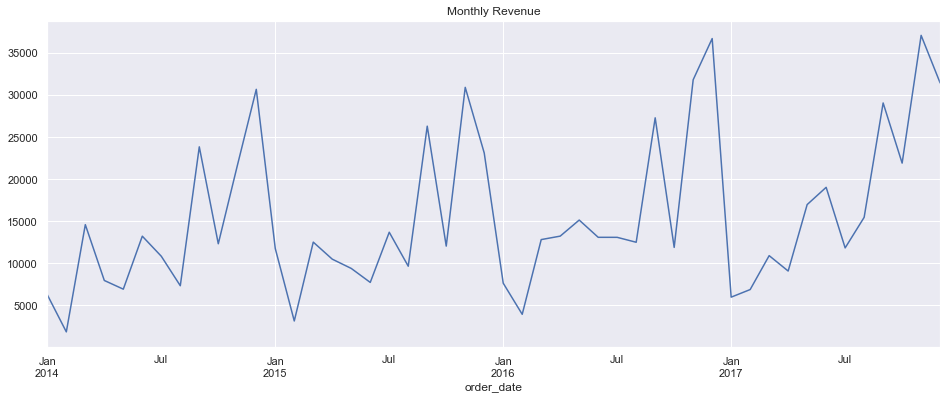

In [27]:
monthly_sales.plot(figsize = (16, 6))
plt.title('Monthly Revenue')
plt.show()

The time series seems to have a seasonality pattern: sales are always low in the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year. 

<function matplotlib.pyplot.show(close=None, block=None)>

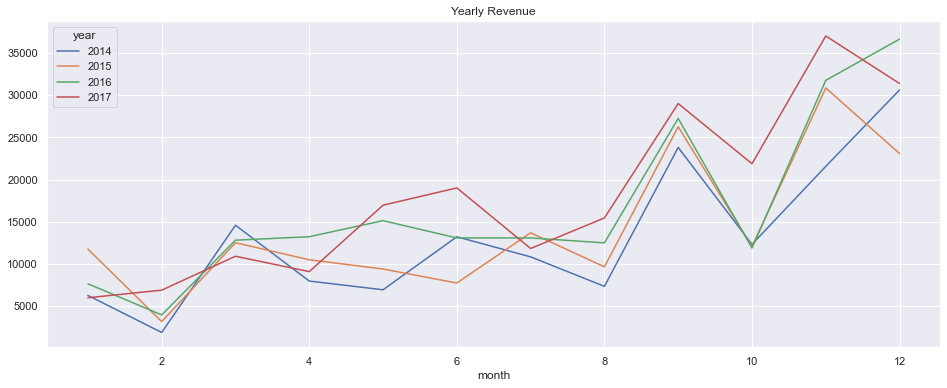

In [28]:
df.groupby(['month', 'year'])['sales'].sum().unstack().plot(figsize = (16, 6))
plt.title('Yearly Revenue')
plt.show

### Decomposition

Decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

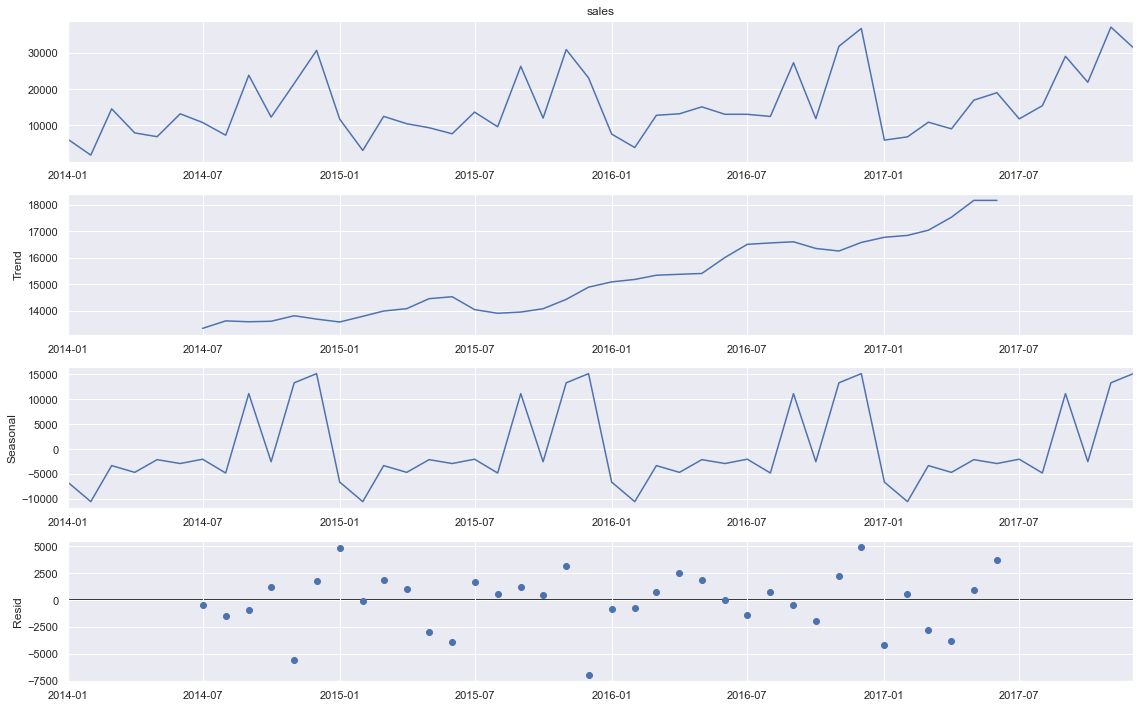

In [29]:
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(monthly_sales, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

### Boxplot

<AxesSubplot:>

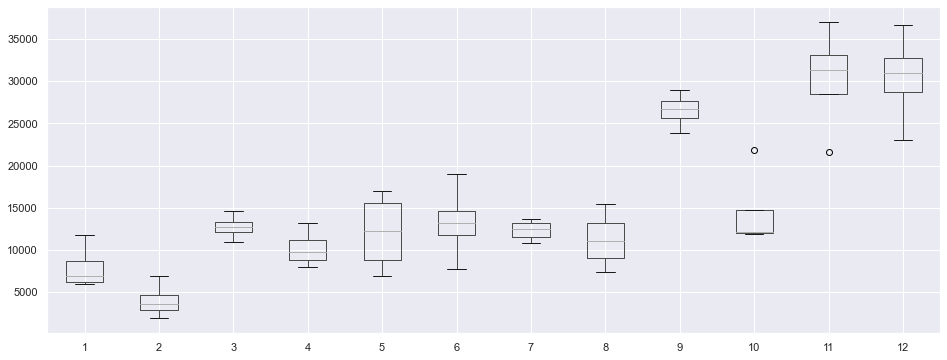

In [30]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
df.groupby(['year','month'])['sales'].sum().unstack().boxplot()

The boxplot chart indicates that there are outliers in October and November. Hypothesis:

- Discounts / promotions
- Increase in ad spend
- Marketing campaigns
- Stock availability

<function matplotlib.pyplot.show(close=None, block=None)>

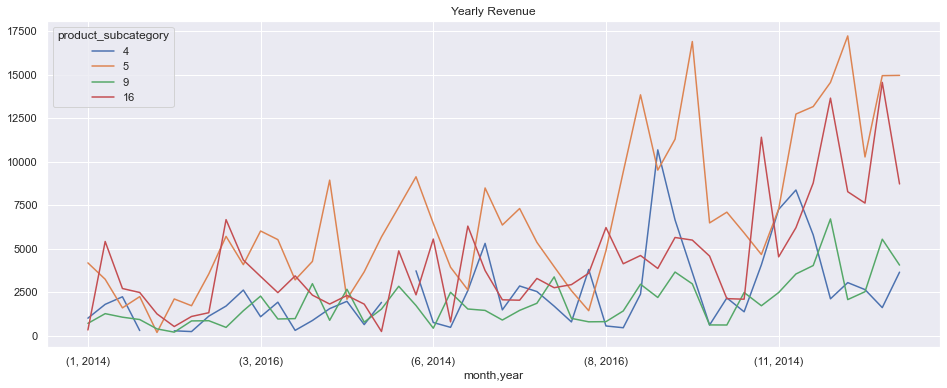

In [31]:
df.groupby(['month', 'year', 'product_subcategory'])['sales'].sum().unstack().plot(figsize = (16, 6))
plt.title('Yearly Revenue')
plt.show

In [32]:
# Calculate Quantile and Interquantile Range
Q1 = df.discount.quantile(0.25)
Q3 = df.discount.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0.3


Interquartile range (IQR) is a measure of where the “middle fifty” is in a data set. In other words, an interquartile range is a measure of where the bulk of the values lie (source: <a href="https://www.statisticshowto.com/probability-and-statistics/interquartile-range/">Statistics How To</a>).

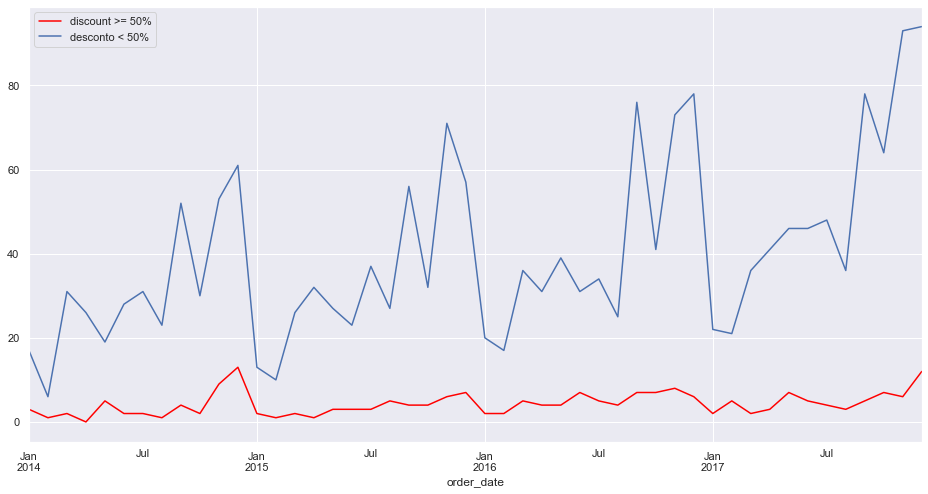

In [33]:
# discount is equal or greater than 50%
discount_g50 = df.loc[(df['discount'] >= 0.5)]
discount_g50 = discount_g50['sales'].resample('MS').count()

# discount is lower than 50%
discount_l50 = df.loc[(df['discount'] < 0.5)]
discount_l50 = discount_l50['sales'].resample('MS').count()

# plot
fig, ax = plt.subplots(figsize = (16, 8))
ax1 = discount_g50.plot(color='red', label='discount >= 50%')
ax2 = discount_l50.plot(label='desconto < 50%')
plt.legend()

In [34]:
df = df['sales'].resample('MS').sum()

### Stationarity Test

In [35]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic: {:.3f}'.format(dftest[0]))
    print('P-value: {:.3f}'.format(dftest[1]))
    print('Critical values: ')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

test_stationarity(df)


Test statistic: -4.699
P-value: 0.000
Critical values: 
	1%: -3.5778480370438146 - The data is  stationary with 99% confidence
	5%: -2.925338105429433 - The data is  stationary with 95% confidence
	10%: -2.6007735310095064 - The data is  stationary with 90% confidence


In [36]:
def kpss_test(series):    
    statistic, p_value, n_lags, critical_values = kpss(series, regression='ct')
    # Format Output
    print(f'KPSS statistics: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Number of lags: {n_lags}')
    print('Critical values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The timeseries is {"not " if p_value < 0.05 else ""} stationary.')

kpss_test(df)

KPSS statistics: 0.13985365422423762
p-value: 0.06138212180696735
Number of lags: 10
Critical values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The timeseries is  stationary.


### Autocorrelation and Partial Autocorrelation

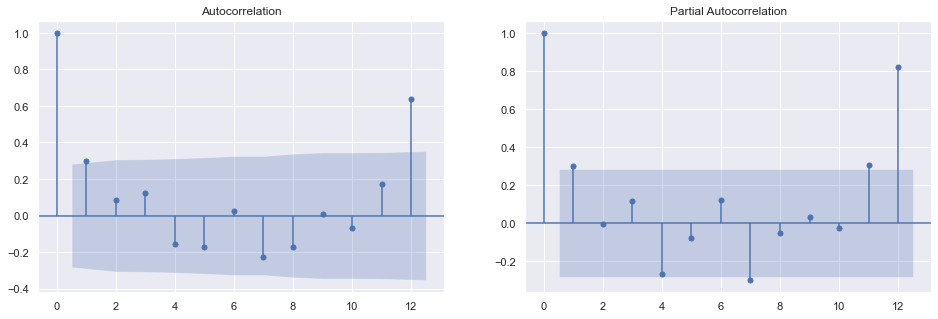

In [37]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
plot_acf(df, ax=ax[0], lags=12, title='Autocorrelation')
plot_pacf(df, ax=ax[1], lags=12, title='Partial Autocorrelation')
plt.show()

## Selecting ARIMA Parameters

### Grid Search

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The above output suggests that ARIMA(1, 1, 1)x(0, 1, 1, 12)12 yields the lowest AIC value of 420.21. Therefore we should consider this to be optimal option.

### Auto Arima

In [ ]:
model = pm.auto_arima(df,               # dataset
                      start_p=0,        # initial p value (AR)
                      start_q=0,        # initial q value (MA)
                      d=None,           # model will determine the optimal d value (I)
                      test='adf',       # model will determine the optimal d value using ADF test (I)
                      max_p=3, max_q=3, # max value of p and q
                      m=12,             # timeseries frequency
                      seasonal=True,    # seasonality
                      start_P=0,        # initial P value
                      D=None,           # model will determine the optimal D value
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Best model:  ARIMA(0,0,0)(0,1,1)[12] intercept

### Fitting the ARIMA model

In [ ]:
model = sm.tsa.statespace.SARIMAX(df,
                                #order=(1,1,1),                    # grid search ARIMA(1, 1, 1)x(0, 1, 1, 12)
                                #seasonal_order=(0, 1, 1, 12),     # grid search 
                                order=(0,0,0),                   # auto arima ARIMA(0,0,0)(0,1,1)[12] 
                                seasonal_order=(0, 1, 1, 12),    # auto arima
                                )
results = model.fit()
print(results.summary())

### Model diagnostics

In [ ]:
results.plot_diagnostics(figsize=(16, 9))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

### Validating forecasts

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int(.95)

ax = df['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = df['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of this forecast is {}'.format(round(mse, 2)))

In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 5596.11 of the real sales.

In [ ]:
# mape
y_truth, y_forecasted = np.array(y_truth), np.array(y_forecasted)
np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100

<table>
    <tr>
        <td>Test</td>
        <td>Grid Search</td>
        <td>Auto ARIMA</td>
    </tr>
    <tr>
        <td>MSE</td>
        <td>30161404.83</td>
        <td>19961161.38</td>
    </tr>
    <tr>
        <td>RMSE</td>
        <td>5491.94</td>
        <td>4467.79</td>
    </tr>
    <tr>
        <td>MAPE</td>
        <td>40.87</td>
        <td>24.22</td>
    </tr>
</table>

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = results.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int(.05)

    ax = y.plot(label='observed', figsize=(16, 6))
    #print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Average']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Inferior Tail','Superior Tail']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [ ]:
final_table = forecast(model,100,df)
final_table.head(12)

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.